# Message passing on trees with `phylax`

In [22]:
import phylax.message as msg
from gcdyn import bdms, mutators, poisson

import jax
import jax.numpy as jnp
import equinox as eqx
import ete3
import numpy as onp
import matplotlib.pyplot as plt

## Example tree

In [2]:
birth_rate = poisson.SigmoidResponse(xscale=2.0, xshift=0.5, yscale=5, yshift=0.0)
death_rate = poisson.ConstantResponse(1.0)
mutation_rate = poisson.ConstantResponse(0.5)
mutator = mutators.GaussianMutator(shift=-0.1, scale=0.1)

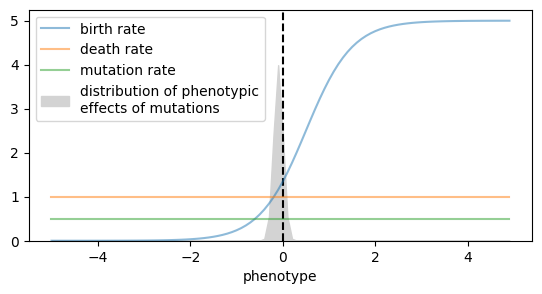

In [3]:
x_grid = onp.arange(-5, 5, 0.1)

plt.figure(figsize=(6.5, 3))
plt.axvline(0, color="k", linestyle="--")
plt.plot(x_grid, birth_rate.λ_phenotype(x_grid), label=f"birth rate", alpha=0.5)
plt.plot(x_grid, death_rate.λ_phenotype(x_grid), label="death rate", alpha=0.5)
plt.plot(x_grid, mutation_rate.λ_phenotype(x_grid), label="mutation rate", alpha=0.5)
plt.fill_between(x_grid, mutator.prob(0, x_grid), color="lightgrey", label="distribution of phenotypic\neffects of mutations")
plt.xlabel('phenotype')
# plt.ylabel('event rate')
plt.ylim(0, None)
plt.legend()
plt.show()

In [4]:
rng = onp.random.default_rng(seed=0)

In [5]:
max_attempts = 1000
for iter in range(max_attempts):
    try:
        tree = bdms.TreeNode()
        tree.x = 0
        tree.evolve(
            10,
            birth_response=birth_rate,
            death_response=death_rate,
            mutation_response=mutation_rate,
            mutator=mutator,
            min_survivors=100,
            capacity=500,
            birth_mutations=False,
            seed=rng,
        )
        n_tips = len(tree)
        n_survivors = sum(node.event == "survival" for node in tree)
        print(f"attempt {iter + 1} succeeded: {n_tips=}, {n_survivors=}")
        break
    except bdms.TreeError as e:
        if iter == max_attempts - 1:
            raise RuntimeError(f"reached {max_attempts=} without success") from e
        continue

attempt 41 succeeded: n_tips=373, n_survivors=104


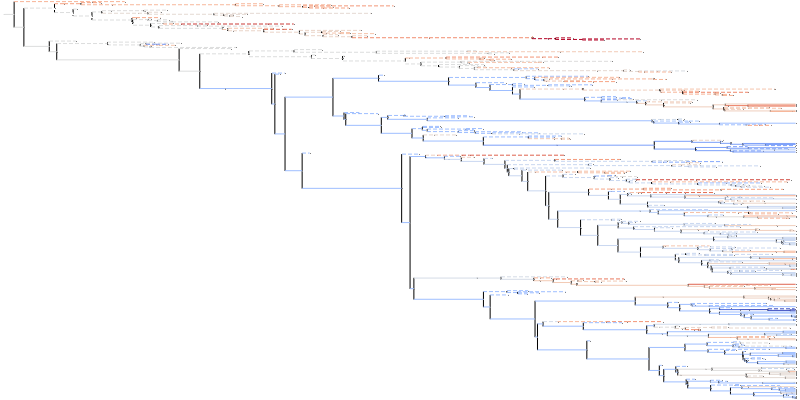

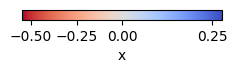

In [6]:
tree.ladderize()
tree.render("x", "%%inline", w=800, h=400)

In [7]:
tree.sample_survivors(p=0.5, seed=rng)
tree.prune()
tree.remove_mutation_events()

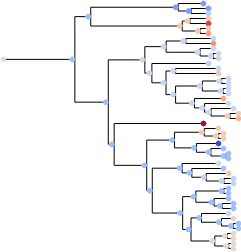

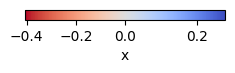

In [8]:
# NBVAL_SKIP

tree.ladderize()

def layout(node):
    node.img_style["size"] = 5

tree.render("x", "%%inline", layout)

## LBI

In [9]:
from jaxtyping import Array, Bool, Int, Float

class UpMessengerLBI(msg.Messenger):
    """Computes the integral of the tree length below the node with an exponential kernel
    
    Args:
        τ: the exponential kernel scale parameter
    """
    τ: Float
    null_value: Float = 0.0

    def __init__(self, τ: Float):
        self.τ = τ

    def __call__(self, child_messages: Float[Array, "c 2"], parent_features: Float) -> Float:
        child_branch_lens = child_messages[:, 0]
        child_lb_downs = child_messages[:, 1]
        branch_integrals = self.τ * (1 - jnp.exp(-child_branch_lens / self.τ))
        discount_factors = jnp.exp(-child_branch_lens / self.τ)
        parent_lb_down = (branch_integrals + discount_factors * child_lb_downs).sum(axis=0)
        return parent_lb_down
    
class DownMessengerLBI(msg.Messenger):
    """Computes the integral of the tree length with an exponential kernel

    Args:
        τ: the exponential kernel scale parameter
    """
    τ: Float
    null_value: Float = 0.0

    def __init__(self, τ: Float):
        self.τ = τ

    def __call__(self, parent_lbi: Float[Array, "p 1"], child_features: Float[Array, " 2"]) -> Float:
        child_branch_len = child_features[0]
        child_lb_down = child_features[1]
        branch_integral = self.τ * (1 - jnp.exp(-child_branch_len / self.τ))
        discount_factor = jnp.exp(-child_branch_len / self.τ)
        # NOTE: parent_lbi might be empty
        child_lbi = child_lb_down + branch_integral + discount_factor * parent_lbi.sum(axis=0)
        # If there is a parent, we have to subtract the duplicated integrals
        child_lbi = child_lbi - (parent_lbi != self.null_value).sum(axis=0) * (child_lb_down + branch_integral)
        return child_lbi

class UpdaterLBI(msg.Updater):
    r: Int = 2

    def __call__(self, node_dist: Float, message: Float) -> Float[Array, " 2"]:
        return jnp.hstack([node_dist, message])
    
class DowndaterLBI(msg.Updater):
    r: Int = 1

    def __call__(self, node_features: Float[Array, " 2"], message: Float) -> Float:
        return jnp.hstack(node_features[1] + message)

In [10]:
message_passer = msg.TreeMessagePasser(tree,
                                       up_messenger=UpMessengerLBI(τ=1.0),
                                       down_messenger=DownMessengerLBI(τ=1.0),
                                       updater=UpdaterLBI(),
                                       downdater=DowndaterLBI())

representations = message_passer.initialize_features(tree, ("dist",))


In [11]:
representations, representations_trajectory = message_passer.upward(representations)

In [12]:
assert jnp.all(representations == representations_trajectory[-1])

for idx in jnp.where(message_passer.leaves)[0]:
    assert representations[idx][1] == 0.0

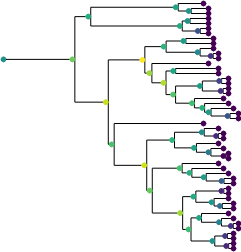

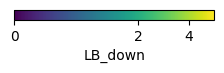

In [13]:
# NBVAL_SKIP

message_passer.decorate(representations[:, 1].squeeze(), tree, "LB_down")

def layout(node):
    node.img_style["size"] = 5

tree.render("LB_down", "%%inline", layout, cmap="viridis")

Any non-leaf node should have nonzero `LB_down`.

In [14]:
for node in tree.traverse():
    if not node.is_leaf():
        assert node.LB_down > 0

In [15]:
representations, representations_trajectory = message_passer.downward(representations)

assert jnp.all(representations == representations_trajectory[-1])

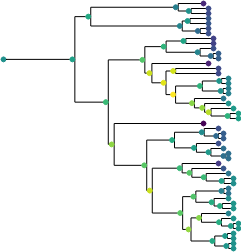

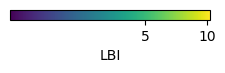

In [16]:
# NBVAL_SKIP

message_passer.decorate(representations.squeeze(), tree, "LBI")

def layout(node):
    node.img_style["size"] = 5

tree.render("LBI", "%%inline", layout, cmap="viridis")

To validate that representations satisfy graph isomorphism, we check that sister leaf nodes match

In [93]:
def is_cherry(node):
    return not node.is_leaf() and len(node.children) > 1 and all(child.is_leaf() for child in node.children)

n_cherries = 0
for cherry in tree.iter_leaves(is_cherry):
    sister_lbis = jnp.array([sister.LBI for sister in cherry.children])
    assert jnp.allclose(*sister_lbis), sister_lbis
    n_cherries += 1
print(f"{n_cherries} cherries validated")

17 cherries validated


In [114]:
class LBImodel(eqx.Module):
    message_passer: msg.TreeMessagePasser
    def __init__(self, tree: ete3.Tree, τ: Float):
        self.message_passer = msg.TreeMessagePasser(tree,
                                                    up_messenger=UpMessengerLBI(τ=τ),
                                                    down_messenger=DownMessengerLBI(τ=τ),
                                                    updater=UpdaterLBI(),
                                                    downdater=DowndaterLBI())

    @eqx.filter_jit
    def __call__(self) -> Float[Array, " n"]:
        out = self.message_passer.branch_lengths[:, None]
        out, _ = self.message_passer.upward(out)
        out, _ = self.message_passer.downward(out)
        return out.squeeze()

In [120]:
@eqx.filter_jit
def loss(model: LBImodel, x: Float[Array, " n"]) -> Float:
    pred_x = jnp.log(model())
    return jnp.mean((x - pred_x) ** 2)

x = jnp.array([node.x for node in tree.traverse(strategy="preorder")])
lbi_model = LBImodel(tree, 1.0)

loss(lbi_model, x)

Array(1.24449688, dtype=float64)

In [105]:
%%timeit
loss(lbi_model, expx)

211 µs ± 5.45 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [96]:
eqx.filter_grad(loss)(lbi_model, expx)#.message_passer.up_messenger.τ

LBImodel(
  message_passer=TreeMessagePasser(
    up_messenger=UpMessengerLBI(null_value=0.0, τ=f64[]),
    down_messenger=DownMessengerLBI(null_value=0.0, τ=f64[]),
    updater=UpdaterLBI(r=None),
    downdater=DowndaterLBI(r=None),
    pre_order_idxs=None,
    post_order_idxs=None,
    parents=BCOO(<invalid>),
    children=BCOO(<invalid>),
    branch_lengths=f64[100],
    leaves=None
  )
)

In [112]:
eqx.filter(lbi_model, lambda node: isinstance(node, msg.Messenger))

LBImodel(
  message_passer=TreeMessagePasser(
    up_messenger=UpMessengerLBI(null_value=0.0, τ=None),
    down_messenger=DownMessengerLBI(null_value=0.0, τ=None),
    updater=UpdaterLBI(r=None),
    downdater=DowndaterLBI(r=None),
    pre_order_idxs=None,
    post_order_idxs=None,
    parents=BCOO(<invalid>),
    children=BCOO(<invalid>),
    branch_lengths=None,
    leaves=None
  )
)

In [113]:
lbi_model

LBImodel(
  message_passer=TreeMessagePasser(
    up_messenger=UpMessengerLBI(null_value=0.0, τ=f64[]),
    down_messenger=DownMessengerLBI(null_value=0.0, τ=f64[]),
    updater=UpdaterLBI(r=2),
    downdater=DowndaterLBI(r=1),
    pre_order_idxs=i64[100],
    post_order_idxs=i64[100],
    parents=BCOO(int64[100, 100], nse=99),
    children=BCOO(int64[100, 100], nse=99),
    branch_lengths=f64[100],
    leaves=bool[100]
  )
)